# Experiments for the Nearest-advocate (NAd) Method for time delay estimation on semi-simulated event-based time-series data

**Methods:**
1. Nearest Advocate (NAd): dense, different sparse-factors and implementations

**Experiments:**
1. runtime for different implementations
1. HP: sparse-factor

## TODO
- [x] Implementation performance tests
- [x] HP-experiment for NAd (optimal sparse_factor, dist_max)

In [1]:
import os
import sys
import time

import numpy as np
np.random.seed(0)

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.signal import correlate, correlation_lags

from multiprocessing import Pool
# Load methods
%matplotlib inline

In [2]:
from data_loader import load_heart_beats, load_breath_rate, load_step_rate

In [3]:
# directories to load
PATH_HEART_RATE_DATA = "../data/HeartBeatData"
PATH_BREATH_RATE_DATA = "../data/BreathRateData"
PATH_STEP_RATE_DATA = "../data/StepRateData"

# parameters for Nearest-Advocate
DIST_MAX = -1           # use the default values for dist_max and dist_padding of nearest_advocate
REGULATE_PADDINGS = True  # regulate the paddings in nearest_advocate
TD_MAX = 300               # search space of 10 minutes
TD_MIN = -300
SAMPLES_PER_S = 10        # precision of the search space (for steps of mean freq 0.5s)

## Data

### Load the datasets

In [4]:
heart_beat_dataset = load_heart_beats(path_to_dir=PATH_HEART_RATE_DATA, verbose=1)

Loading files S18_11_nn.txt and S18_1_beats_synced.csv.
Loading files S18_21_nn.txt and S18_2_beats_synced.csv.
Loading files S19_11_nn.txt and S19_1_beats_synced.csv.
Loading files S20_11_nn.txt and S20_1_beats_synced.csv.
Loading files S20_21_nn.txt and S20_2_beats_synced.csv.
Loading files S21_11_nn.txt and S21_1_beats_synced.csv.
Loading files S21_21_nn.txt and S21_2_beats_synced.csv.
Loading files S23_11_nn.txt and S23_1_beats_synced.csv.
Loading files S23_21_nn.txt and S23_2_beats_synced.csv.
Loading files S24_11_nn.txt and S24_1_beats_synced.csv.
Loading files S24_21_nn.txt and S24_2_beats_synced.csv.
Loading files S26_11_nn.txt and S26_1_beats_synced.csv.
Loading files S27_11_nn.txt and S27_1_beats_synced.csv.
Loading files S28_11_nn.txt and S28_1_beats_synced.csv.
Loading files S28_21_nn.txt and S28_2_beats_synced.csv.
Loading files S29_11_nn.txt and S29_1_beats_synced.csv.
Loading files S29_21_nn.txt and S29_2_beats_synced.csv.


In [5]:
breath_rate_dataset = load_breath_rate(path_to_dir=PATH_BREATH_RATE_DATA, verbose=1)

Loading files P04_Reference_FlowReversals_OVERALL.csv and P04_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P05_Reference_FlowReversals_OVERALL.csv and P05_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P06_Reference_FlowReversals_OVERALL.csv and P06_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P07_Reference_FlowReversals_OVERALL.csv and P07_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P08_Reference_FlowReversals_OVERALL.csv and P08_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P09_Reference_FlowReversals_OVERALL.csv and P09_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P10_Reference_FlowReversals_OVERALL.csv and P10_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P11_Reference_FlowReversals_OVERALL.csv and P11_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P12_Reference_FlowReversals_OVERALL.csv and P12_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P13_Reference_FlowReversals_OVERALL.csv and P13_SportsSRS_FlowReversals_OVERALL.csv.
Loading fi

In [6]:
step_rate_dataset = load_step_rate(path_to_dir=PATH_STEP_RATE_DATA, verbose=1)

Loading files P04_Reference_Strides_OVERALL.csv and P04_SportsSRS_Strides_OVERALL.csv.
Loading files P05_Reference_Strides_OVERALL.csv and P05_SportsSRS_Strides_OVERALL.csv.
Loading files P06_Reference_Strides_OVERALL.csv and P06_SportsSRS_Strides_OVERALL.csv.
Loading files P07_Reference_Strides_OVERALL.csv and P07_SportsSRS_Strides_OVERALL.csv.
Loading files P08_Reference_Strides_OVERALL.csv and P08_SportsSRS_Strides_OVERALL.csv.
Loading files P09_Reference_Strides_OVERALL.csv and P09_SportsSRS_Strides_OVERALL.csv.
Loading files P10_Reference_Strides_OVERALL.csv and P10_SportsSRS_Strides_OVERALL.csv.
Loading files P11_Reference_Strides_OVERALL.csv and P11_SportsSRS_Strides_OVERALL.csv.
Loading files P12_Reference_Strides_OVERALL.csv and P12_SportsSRS_Strides_OVERALL.csv.
Loading files P13_Reference_Strides_OVERALL.csv and P13_SportsSRS_Strides_OVERALL.csv.
Loading files P14_Reference_Strides_OVERALL.csv and P14_SportsSRS_Strides_OVERALL.csv.
Loading files P15_Reference_Strides_OVERALL

## Function to semi-simulate the data

In [7]:
def modify_timeseries(arr: np.ndarray, offset: float=0, subselect_length=None, 
                      sigma: float=0.0, fraction: float=1.0, miss_block=0.0, time_warp_scale=0.0):
    """Modify a event-based timeseries in order generate semi-simulated data.
    
    Parameters
    ----------
    arr: np.ndarray
        Array to modify
    offset: float
        Offset to shift the time-series
    sigma: float
        Amount of noise, relative to the median difference of subsequent events
    fraction: float
        Fraction of events used
        
    Returns
    -------
    arr_modified : np.ndarray
        Modified array
    """
    arr_mod = arr.copy()
    
    # shift the array
    arr_mod += offset
    
    # select part
    if subselect_length:
        start_idx = np.random.randint(0, max(1, len(arr_mod)-subselect_length))
        arr_mod = arr_mod[start_idx:start_idx+subselect_length]
            
    # add gaussian noise to the events
    arr_mod = arr_mod + np.random.normal(loc=0, scale=sigma*np.median(np.diff(arr)), size=len(arr_mod))
    
    # sort the array to maintain continuity
    arr_mod.sort()
    
    # select the fraction of events
    if fraction < 1.0:
        arr_mod = arr_mod[np.random.random(len(arr_mod))<fraction]
        
    if miss_block > 0.0:
        start_idx = np.random.randint(0, max(1, len(arr_mod)-int((miss_block*len(arr_mod)))))
        mask = np.zeros(len(arr_mod), dtype=bool)
        mask[:start_idx] = True
        mask[start_idx+int(miss_block*len(arr_mod)):] = True
        arr_mod = arr_mod[mask]
        
    # linear time-warping
    if time_warp_scale > 0.0:
        pivot = arr_mod[len(arr_mod)//2]
        # warp_scale = np.random.normal(loc=1, scale=time_warp_scale)
        if np.random.rand() > 0.5:
            warp_scale = 1 + time_warp_scale
        else:
            warp_scale = 1 - time_warp_scale
        arr_mod = (arr_mod-pivot) * warp_scale + pivot

    return arr_mod

modify_timeseries(arr=heart_beat_dataset[0][0], offset=np.pi, subselect_length=10, sigma=0.1, fraction=0.5, 
                  time_warp_scale=0.005, miss_block=0.1)

array([1985.24451403, 1985.93036049, 1987.22308435, 1988.88626154,
       1990.3797134 ])

In [8]:
# create dummy time-series
arr_ref = np.cumsum(np.random.normal(loc=1, scale=0.25, size=600))
arr_sig = modify_timeseries(arr=arr_ref, offset=np.pi, sigma=0.1, fraction=0.99)

## Performance comparision for different implementations

In [9]:
N = 10_000               # number of events in the random arrays
TIME_SHIFT = np.pi        # true time-shift between the two arrays
DEF_DIST = 0.25           # default values for dist_max and dist_padding of nearest_advocate

In [10]:
sys.path.append("../src")

In [11]:
# Create two related event-based array, they differ by a time-shift and gaussian noise
arr_ref = np.sort(np.cumsum(np.random.normal(loc=1, scale=0.25, size=N)))
arr_sig = np.sort(arr_ref + TIME_SHIFT + np.random.normal(loc=0, scale=0.1, size=N))

In [12]:
# Time the numba-solution
from nearest_advocate_nb import nearest_advocate
# run once before the test to just-in-time compile it
np_nearest = nearest_advocate(arr_ref=arr_ref, arr_sig=arr_sig, 
                              td_min=-1, td_max=1, sps=SAMPLES_PER_S, sparse_factor=1, 
                              dist_max=DEF_DIST, regulate_paddings=REGULATE_PADDINGS, dist_padding=DEF_DIST)

start_time = time.time()
np_nearest = nearest_advocate(arr_ref=arr_ref, arr_sig=arr_sig, 
                              td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, sparse_factor=1, 
                              dist_max=DEF_DIST, regulate_paddings=REGULATE_PADDINGS, dist_padding=DEF_DIST)
pytime = time.time() - start_time
time_shift, min_mean_dist = np_nearest[np.argmin(np_nearest[:,1])]
print(f"Numba:   \t{pytime:.8f} s, \t detected time shift: {time_shift:.2f} s, \t minimal mean distance: {min_mean_dist:.6f} s")

Numba:   	0.31010461 s, 	 detected time shift: 3.10 s, 	 minimal mean distance: 0.085389 s


In [13]:
%%timeit -n 1000 -r 7
_ = nearest_advocate(arr_ref=arr_ref, arr_sig=arr_sig, 
                              td_min=-1, td_max=1, sps=SAMPLES_PER_S, sparse_factor=1, 
                              dist_max=DEF_DIST, regulate_paddings=REGULATE_PADDINGS, dist_padding=DEF_DIST)

1.02 ms ± 2.14 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [14]:
# Time the Cython-solution
from nearest_advocate_c import nearest_advocate
start_time = time.time()
np_nearest = nearest_advocate(arr_ref=arr_ref.astype(np.float32), arr_sig=arr_sig.astype(np.float32), 
                                td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, sparse_factor=1, 
                                dist_max=DEF_DIST, regulate_paddings=REGULATE_PADDINGS, dist_padding=DEF_DIST)
pytime = time.time() - start_time
time_shift, min_mean_dist = np_nearest[np.argmin(np_nearest[:,1])]
print(f"Cython:   \t{pytime:.8f} s, \t detected time shift: {time_shift:.2f} s, \t minimal mean distance: {min_mean_dist:.6f} s")

Cython:   	0.27966404 s, 	 detected time shift: 3.10 s, 	 minimal mean distance: 0.085395 s


In [15]:
%%timeit -n 1000 -r 7
_ = nearest_advocate(arr_ref=arr_ref.astype(np.float32), arr_sig=arr_sig.astype(np.float32), 
                              td_min=-1, td_max=1, sps=SAMPLES_PER_S, sparse_factor=1, 
                              dist_max=DEF_DIST, regulate_paddings=REGULATE_PADDINGS, dist_padding=DEF_DIST)

916 µs ± 2.99 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [16]:
# Time the pure Python-solution
from nearest_advocate_python import nearest_advocate
start_time = time.time()
np_nearest = nearest_advocate(arr_ref=arr_ref, arr_sig=arr_sig, 
                              td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, sparse_factor=1, 
                              dist_max=DEF_DIST, regulate_paddings=REGULATE_PADDINGS, dist_padding=DEF_DIST)
pytime = time.time() - start_time
time_shift, min_mean_dist = np_nearest[np.argmin(np_nearest[:,1])]
print(f"Python:   \t{pytime:.8f} s, \t detected time shift: {time_shift:.2f} s, \t minimal mean distance: {min_mean_dist:.6f} s")


Python:   	67.38667846 s, 	 detected time shift: 3.10 s, 	 minimal mean distance: 0.085389 s


In [17]:
%%timeit -n 1 -r 7
_ = nearest_advocate(arr_ref=arr_ref, arr_sig=arr_sig, 
                              td_min=-1, td_max=1, sps=SAMPLES_PER_S, sparse_factor=1, 
                              dist_max=DEF_DIST, regulate_paddings=REGULATE_PADDINGS, dist_padding=DEF_DIST)

222 ms ± 949 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
(0.919-1.01)/0.919

-0.0990206746463547

## Define Methods

Found optimum for a time shift of 3.140s in 0.903s


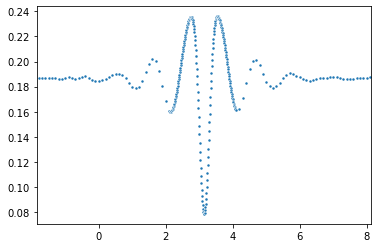

In [19]:
import numpy as np
from numba import njit


@njit(parallel=False)
def nearest_advocate_single(arr_ref: np.ndarray, arr_sig: np.ndarray, 
                            dist_max: float, dist_padding: float, regulate_paddings: bool=True):
    '''Calculates the synchronicity of two arrays of timestamps in terms of the mean of all minimal distances between each event in arr_sig and it's nearest advocate in arr_ref.
    arr_ref (np.array): Reference array or timestamps assumed to be correct
    arr_sig (np.array): Signal array of  timestamps, assumed to be shifted by an unknown constant time-delta
    dist_max (float): Maximal accepted distances, should be 1/4 of the median gap of arr_ref
    regulate_paddings (bool): Regulate non-overlapping events in arr_sig with a maximum distance of err_max, default True
    dist_padding (float): Distance assigned to non-overlapping (padding) events, should be 1/4 of the median gap of arr_ref. Only given if regulate_paddings is True
    '''
    # Assert input properties
    assert arr_ref.shape[0] > 0    # reference array must be non-empty
    assert arr_sig.shape[0] > 0    # signal array must be non-empty
    assert dist_max > 0.0          # maximal distance must be greater than 0.0
    if regulate_paddings:
        assert dist_padding > 0.0  # maximal distance for paddings must be greater than 0.0

    # store the lengths of the arrays
    l_arr_ref = len(arr_ref)
    l_arr_sig = len(arr_sig)
            
    ref_idx = 0              # index for arr_ref
    sig_idx = 0              # index for arr_sig
    counter = 0              # number of advocate events
    cum_distance = 0.0       # cumulative distances between advocate events
    
    # Step 1: cut leading reference timestamps without finding advocates
    while ref_idx+1 < l_arr_ref and arr_ref[ref_idx+1] <= arr_sig[sig_idx]:
        ref_idx += 1
        
    # return dist_max, if arr_ref ends before arr_sig starts
    if ref_idx+1 == l_arr_ref:
        return dist_max
    
    # Case: arr_ref[ref_idx] < arr_sig[sig_idx] < arr_ref[ref_idx+1]
    assert arr_ref[ref_idx+1] > arr_sig[sig_idx]
    
    # Step 2: count leading signal timestamps with finding advocates
    while sig_idx < l_arr_sig and arr_sig[sig_idx] < arr_ref[ref_idx]:
        # Invariant: arr_ref[ref_idx] < arr_sig[sig_idx] < arr_ref[ref_idx+1]
        if regulate_paddings:
            cum_distance += min(arr_ref[ref_idx]-arr_sig[sig_idx], dist_padding)
            counter += 1
        sig_idx += 1
        
    # return dist_max, if arr_sig ends before arr_ref starts
    if sig_idx == l_arr_sig:
        return dist_max     
    
    # Step 3 (regular case) and step 4 (match trailing signal timestamps)
    while sig_idx < l_arr_sig:
        # Step 3: regular case
        if arr_sig[sig_idx] < arr_ref[-1]:
            # forward arr_ref and then arr_sig until regalar case
            while ref_idx+1 < l_arr_ref and arr_ref[ref_idx+1] <= arr_sig[sig_idx]:
                ref_idx += 1
            if ref_idx+1 >= l_arr_ref: 
                sig_idx += 1
                continue
            # Invariant: arr_ref[ref_idx] < arr_sig[sig_idx] < arr_ref[ref_idx+1]
            # assert arr_ref[ref_idx] <= arr_sig[sig_idx]
            # assert arr_sig[sig_idx] < arr_ref[ref_idx+1]
            
            cum_distance += min(arr_sig[sig_idx]-arr_ref[ref_idx], arr_ref[ref_idx+1]-arr_sig[sig_idx], dist_max) 
            counter += 1
        # Step 4: match trailing reference timestamps with last signal timestamp
        elif regulate_paddings:  
            # Invariant: arr_ref[ref_idx+1] <= arr_sig[sig_idx], given by the else case
            if arr_sig[sig_idx]-arr_ref[ref_idx+1] < dist_padding:
                cum_distance += arr_sig[sig_idx]-arr_ref[ref_idx+1]
                counter += 1
            else: 
                # case with only dist_padding increments from now on
                cum_distance += (l_arr_sig - sig_idx) * dist_padding
                counter += (l_arr_sig - sig_idx)
                break # stop, because the last values can be aggregated
                
        sig_idx += 1
    
    # return mean cumulative distance between found advocate events
    return cum_distance / counter


@njit(parallel=False)
def nearest_advocate(arr_ref: np.ndarray, arr_sig: np.ndarray, 
                     td_min: float, td_max: float, td_prox: float=1.0, sps: float=10, sparse_factor: int=1, 
                     dist_max: float=0.0, regulate_paddings: bool=True, dist_padding: float=0.0):
    '''Calculates the synchronicity of two arrays of timestamps for a search space between td_min and td_max with a precision of 1/sps. The synchronicity is given by the mean of all minimal distances between each event in arr_sig and it's nearest advocate in arr_ref.
    arr_ref (np.array): Reference array or timestamps assumed to be correct
    arr_sig (np.array): Signal array of  timestamps, assumed to be shifted by an unknown constant time-delta
    td_min (float): lower bound of the search space for the time-shift
    td_max (float): upper bound of the search space for the time-shift
    sps (int): number of investigated time-shifts per second, should be higher than 10 times the number of median gap of arr_ref (default 10).
    sparse_factor (int): factor for the sparseness of arr_sig for the calculation, higher is faster but may be less accurate (default 1)
    dist_max (None, float): Maximal accepted distances, default None: 1/4 of the median gap of arr_ref
    dist_padding (None, float): Assumed distances of non-overlapping (padding) matches, default None: 1/4 of the median gap of arr_ref
    regulate_paddings (bool): regulate non-overlapping events in arr_sig with a maximum distance of err_max
    '''
    # set the default values for dist_max, dist_padding relative if not set
    # TODO improve default value: min(np.median(np.diff(arr_sig)), np.median(np.diff(arr_ref))) / 4
    if dist_max <= 0.0:
        dist_max = np.median(np.diff(arr_ref))/4
    if dist_padding <= 0.0:
        dist_padding = np.median(np.diff(arr_ref))/4
        
    # Random subsample and create a copy of arr_sig once, as it could lead to problems otherwise
    if sparse_factor > 1:
        probe = arr_sig[sparse_factor//2::sparse_factor].copy()
    else:
        probe = arr_sig.copy()
    
    # Create an k x 2 matrix to store the investigated time-shifts and their respective mean distance
    broad_search_n_samples = int((td_max-td_min)*sps)
    fine_search_n_samples = int(2*10*td_prox*sps)   # fine search with factor 1/10 sampling
    time_delays = np.empty((broad_search_n_samples+fine_search_n_samples, 2), dtype=np.float32)
    time_delays[:broad_search_n_samples, 0] = np.arange(td_min, td_max, 1/sps)
    # Calculate the mean distance for all time-shifts in the search space. 
    # The shift with the lowest mean distance is the best fit for the time-shift
    idx = 0
    while idx < broad_search_n_samples:
        # calculate the nearest advocate criteria
        time_delays[idx,1] = nearest_advocate_single(
             arr_ref, 
             probe-time_delays[idx,0],  # the signal array is shifted by a time-delta
             dist_max=dist_max, regulate_paddings=regulate_paddings, dist_padding=dist_padding)
        idx += 1
    
    # finesearch around the peak
    time_shift, min_mean_dist = time_delays[np.argmin(time_delays[:broad_search_n_samples,1])]
    time_delays[broad_search_n_samples:, 0] = np.arange(time_shift-td_prox, time_shift+td_prox, 1/sps/10)
    # Calculate the mean distance for all time-shifts in the search space. 
    while idx < time_delays.shape[0]:
        # calculate the nearest advocate criteria
        time_delays[idx,1] = nearest_advocate_single(
             arr_ref, 
             probe-time_delays[idx,0],  # the signal array is shifted by a time-delta
             dist_max=dist_max, regulate_paddings=regulate_paddings, dist_padding=dist_padding)
        idx += 1     
    return time_delays

# run once before the test to just-in-time compile it
start_time = time.time()
time_delays = nearest_advocate(arr_ref=arr_ref, arr_sig=arr_sig, 
                             td_min=-10, td_max=10, td_prox=1, sps=SAMPLES_PER_S, sparse_factor=1, 
                             dist_max=DIST_MAX, regulate_paddings=REGULATE_PADDINGS, dist_padding=DIST_MAX)
time_shift, min_mean_dist = time_delays[np.argmin(time_delays[:,1])]
print(f"Found optimum for a time shift of {time_shift:.3f}s in {time.time()-start_time:.3f}s")

sns.scatterplot(x=time_delays[:,0], y=time_delays[:,1], marker='.')
plt.xlim(time_shift-5.0, time_shift+5.0)
plt.show()

## Hyperparameter Optimization for Nearest-Advocate

### Experiment 1: Find the optimal sparse-factor

In [22]:
LENGTHS = [int(l) for l in [1e1, 2e1, 5e1, 1e2, 2e2, 5e2, 1e3, 2e3, 5e3, 1e4, 2e4, 5e4, 1e5, 2e5, 5e5, 1e6]]

N_ITERATIONS = 20         # number of iterations per length, used for the interquartils
METHODS = ['NAd-dense', 'NAd-sparse10', 'NAd-sparse100', 'NAd-sparse1000', 'NAd-sparseopt']  # TODO: add method specifics
REF_SIGMA = 0.5
SIGMA = 0.25
FRACTION = 0.9
DIST_MAX = -1.0

In [ ]:
# evaluate a given length
def evaluate_length(iteration):
    # define the local DataFrame for one single pair
    df_runtimes = pd.DataFrame({m: np.nan*np.zeros(len(LENGTHS)) for m in METHODS})
    df_runtimes["length"] = LENGTHS
    df_precision = pd.DataFrame({m: np.nan*np.zeros(len(LENGTHS)) for m in METHODS})
    df_precision["length"] = LENGTHS

    # dummy evaluation for JIT-compiliation
    _ = nearest_advocate(
                arr_ref=np.array([1.0, 2.0, 3.0]).astype(np.float32), arr_sig=np.array([1.0, 2.0, 3.0]).astype(np.float32), 
                td_min=-1, td_max=+1, sps=SAMPLES_PER_S, sparse_factor=1, 
                dist_max=DIST_MAX, regulate_paddings=REGULATE_PADDINGS, dist_padding=DIST_MAX)
    
    for idx, length in enumerate(LENGTHS):
        np.random.seed(N_ITERATIONS*iteration+idx)
        l_bound, u_bound = max(TD_MIN, -length/2), min(TD_MAX, length/2)
        offset = np.random.random() * (u_bound-l_bound) + l_bound
        # Create two related event-based array, they differ by a time-shift and gaussian noise
        arr_ref = np.sort(np.cumsum(np.random.normal(loc=1, scale=REF_SIGMA, size=int(length)))).astype(np.float32)
        arr_sig = np.sort(arr_ref + offset + np.random.normal(loc=0, scale=SIGMA, size=int(length))).astype(np.float32)

        # NAd-dense
        start_time = time.time()
        np_nearest = nearest_advocate(
            arr_ref=arr_ref, arr_sig=arr_sig, 
            td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, sparse_factor=1, 
            dist_max=DIST_MAX, regulate_paddings=REGULATE_PADDINGS, dist_padding=DIST_MAX)
        time_shift, min_mean_dist = np_nearest[np.argmin(np_nearest[:,1])]
        df_runtimes.loc[idx, "NAd-dense"] = time.time() - start_time
        df_precision.loc[idx, "NAd-dense"] = np.abs(time_shift-offset)

        # NAd-sparse10
        start_time = time.time()
        np_nearest = nearest_advocate(
            arr_ref=arr_ref, arr_sig=arr_sig, 
            td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, sparse_factor=10, 
            dist_max=DIST_MAX, regulate_paddings=REGULATE_PADDINGS, dist_padding=DIST_MAX)
        time_shift, min_mean_dist = np_nearest[np.argmin(np_nearest[:,1])]
        df_runtimes.loc[idx, "NAd-sparse10"] = time.time() - start_time
        df_precision.loc[idx, "NAd-sparse10"] = np.abs(time_shift-offset)

        # NAd-sparse100
        start_time = time.time()
        try:
            np_nearest = nearest_advocate(
                arr_ref=arr_ref, arr_sig=arr_sig, 
                td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, sparse_factor=100, 
                dist_max=DIST_MAX, regulate_paddings=REGULATE_PADDINGS, dist_padding=DIST_MAX)
            time_shift, min_mean_dist = np_nearest[np.argmin(np_nearest[:,1])]
            df_runtimes.loc[idx, "NAd-sparse100"] = time.time() - start_time
            df_precision.loc[idx, "NAd-sparse100"] = np.abs(time_shift-offset)
        except AssertionError:
            pass
            # print(f"WARNING: AssertionError, skipping.")

        # NAd-sparse1000
        start_time = time.time()
        try:
            np_nearest = nearest_advocate(
                arr_ref=arr_ref, arr_sig=arr_sig, 
                td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, sparse_factor=1000, 
                dist_max=DIST_MAX, regulate_paddings=REGULATE_PADDINGS, dist_padding=DIST_MAX)
            time_shift, min_mean_dist = np_nearest[np.argmin(np_nearest[:,1])]
            df_runtimes.loc[idx, "NAd-sparse1000"] = time.time() - start_time
            df_precision.loc[idx, "NAd-sparse1000"] = np.abs(time_shift-offset)
        except AssertionError:
            pass
            # print(f"WARNING: AssertionError, skipping.")

        # NAd-sparseopt
        start_time = time.time()
        try:
            sparse_optimal = int(max(1, length/250))
            np_nearest = nearest_advocate(
                arr_ref=arr_ref, arr_sig=arr_sig, 
                td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, sparse_factor=sparse_optimal, 
                dist_max=DIST_MAX, regulate_paddings=REGULATE_PADDINGS, dist_padding=DIST_MAX)
            time_shift, min_mean_dist = np_nearest[np.argmin(np_nearest[:,1])]
            df_runtimes.loc[idx, "NAd-sparseopt"] = time.time() - start_time
            df_precision.loc[idx, "NAd-sparseopt"] = np.abs(time_shift-offset)
        except AssertionError:
            pass
            # print(f"WARNING: AssertionError, skipping.")
    
    return df_runtimes, df_precision
    
# Initialize the pool with the number of processes
with Pool(processes=30) as pool: 
    results = pool.map(evaluate_length, range(N_ITERATIONS))
df_runtimes = pd.concat([res[0] for res in results]).sort_values("length")
df_precision = pd.concat([res[1] for res in results]).sort_values("length")

In [ ]:
for length in LENGTHS:
    sparse_optimal = int(max(1, length/250))
    print(f"Lenght={length}, optimal sparse factor: {sparse_optimal}")

Lenght=10, optimal sparse factor: 1
Lenght=20, optimal sparse factor: 1
Lenght=50, optimal sparse factor: 1
Lenght=100, optimal sparse factor: 1
Lenght=200, optimal sparse factor: 1
Lenght=500, optimal sparse factor: 2
Lenght=1000, optimal sparse factor: 4
Lenght=2000, optimal sparse factor: 8
Lenght=5000, optimal sparse factor: 20
Lenght=10000, optimal sparse factor: 40
Lenght=20000, optimal sparse factor: 80
Lenght=50000, optimal sparse factor: 200
Lenght=100000, optimal sparse factor: 400
Lenght=200000, optimal sparse factor: 800
Lenght=500000, optimal sparse factor: 2000
Lenght=1000000, optimal sparse factor: 4000


In [ ]:
df_runtimes.sample(5)

,NAd-dense,NAd-sparse10,NAd-sparse100,NAd-sparse1000,NAd-sparseopt,length
11,2.588090,0.490331,0.184154,0.153442,0.167942,50000
10,1.030101,0.191455,0.075385,0.065963,0.083261,20000
2,0.000712,0.000404,NaN,NaN,0.000705,50
11,2.586648,0.493439,0.184148,0.152803,0.167417,50000
0,0.000350,0.000217,NaN,NaN,0.000338,10


In [ ]:
df_precision.sample(5)

,NAd-dense,NAd-sparse10,NAd-sparse100,NAd-sparse1000,NAd-sparseopt,length
5,0.092529,34.712524,77.767475,NaN,0.182526,500
6,0.051794,0.028208,65.131788,2.978205,0.031789,1000
4,0.048685,8.198694,40.811312,NaN,0.048685,200
4,0.015531,0.215528,7.224474,NaN,0.015531,200
0,0.016870,1.576870,NaN,NaN,0.016870,10


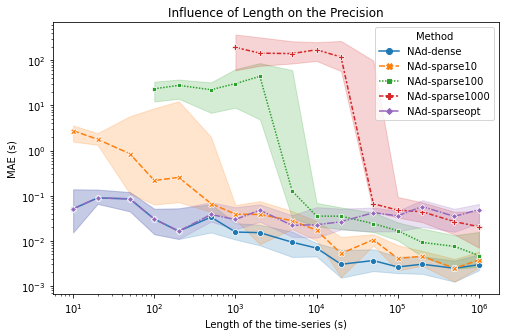

In [ ]:
fig, axes = plt.subplots(1,1, figsize=(8, 5))

# melt the DataFrame
df_precision_melted = pd.melt(df_precision, id_vars="length", var_name="Method", 
                              value_vars=METHODS, value_name="precision")
precision_plot = sns.lineplot(data=df_precision_melted, 
                              x="length", y="precision", 
                              hue="Method", style="Method", markers=True,
                              estimator=np.median, errorbar=lambda x: (np.quantile(x, 0.25), np.quantile(x, 0.75)))

plt.title("Influence of Length on the Precision")
plt.xlabel("Length of the time-series (s)")
plt.ylabel("MAE (s)")
# plt.ylim((0.02, 50))
precision_plot.set(xscale='log')
precision_plot.set(yscale='log')
plt.show()

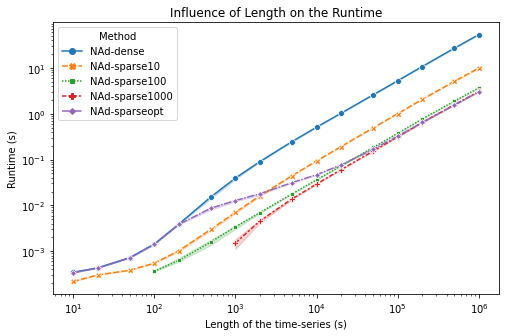

In [ ]:
fig, axes = plt.subplots(1,1, figsize=(8, 5))

# melt the DataFrame
df_runtimes_melted = pd.melt(df_runtimes, id_vars="length", var_name="Method", 
                              value_vars=METHODS, value_name="runtime")
precision_plot = sns.lineplot(data=df_runtimes_melted, 
                              x="length", y="runtime", 
                              hue="Method", style="Method", markers=True,
                              estimator=np.median, errorbar=lambda x: (np.quantile(x, 0.25), np.quantile(x, 0.75)))

plt.title("Influence of Length on the Runtime")
plt.xlabel("Length of the time-series (s)")
plt.ylabel("Runtime (s)")
precision_plot.set(xscale='log')
precision_plot.set(yscale='log')
plt.show()

### NAd-Optimization - Experiment 1: Robustness against missing events

TODO: check the results, they are not as expected

In [ ]:
FRACTIONS = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
METHODS = ['NAd-median', 'NAd-minmedian', 'NAd-mean', 'NAd-minmean']  # TODO: add method specifics

# offset = np.pi  # this is randomly sampled now
SUBSELECT_LENGTH = 1000
SIGMA = 0.1               # run with a relative sigma of 0.1
TIME_WARP_SCALE = 0.0

In [30]:
# evaluate a given fraction
def evaluate_fraction(fraction):
    # generate semi-simulated pairs of measurements
    measurements = (heart_beat_dataset + breath_rate_dataset + step_rate_dataset)
    # measurements = (breath_rate_dataset)
    semi_simulated_pairs = list()
    n_measurements = 0
    for measurement in measurements:
        for array in measurement:
            l_bound = max(TD_MIN, -len(array)/2, -SUBSELECT_LENGTH)
            u_bound = min(TD_MAX, len(array)/2, SUBSELECT_LENGTH)
            offset = np.random.random() * (u_bound-l_bound) + l_bound
            semi_simulated_pairs.append(
                (array, modify_timeseries(arr=array, offset=offset, subselect_length=SUBSELECT_LENGTH, 
                                          sigma=SIGMA, fraction=fraction, time_warp_scale=TIME_WARP_SCALE),
                offset)
            )
            n_measurements += 1
    assert n_measurements == 2 * len(measurements)  # otherwise there ar !=2 arrays per measurement
    
    # define the local DataFrame for one single pair
    df_precision = pd.DataFrame({m: np.nan*np.zeros(n_measurements) for m in METHODS})
    df_precision["fraction"] = [fraction for _ in range(n_measurements)]

    # loop through all semi-simulated pairs
    for idx, (arr_ref, arr_sig, offset) in enumerate(semi_simulated_pairs):
        # arr_ref = modify_timeseries(arr=arr_ref_orig, offset=0.0, sigma=SIGMA, fraction=fraction)
        
        # # NAd-dense
        # start_time = time.time()
        # np_nearest = nearest_advocate(
        #     arr_ref=arr_ref, arr_sig=arr_sig, 
        #     td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, sparse_factor=1, 
        #     dist_max=DIST_MAX, regulate_paddings=REGULATE_PADDINGS, dist_padding=DIST_MAX)
        # time_shift, min_mean_dist = np_nearest[np.argmin(np_nearest[:,1])]
        # df_precision.loc[idx, "NAd-dense"] = np.abs(time_shift-offset)

        # NAd-median
        start_time = time.time()
        dist_max = np.median(np.diff(arr_ref)) / 4
        np_nearest = nearest_advocate(
            arr_ref=arr_ref, arr_sig=arr_sig, 
            td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, sparse_factor=1, 
            dist_max=dist_max, regulate_paddings=REGULATE_PADDINGS, dist_padding=dist_max)
        time_shift, min_mean_dist = np_nearest[np.argmin(np_nearest[:,1])]
        df_precision.loc[idx, "NAd-median"] = np.abs(time_shift-offset)

        # NAd-minmedian
        start_time = time.time()
        dist_max = min(np.median(np.diff(arr_sig)), np.median(np.diff(arr_ref))) / 4
        np_nearest = nearest_advocate(
            arr_ref=arr_ref, arr_sig=arr_sig, 
            td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, sparse_factor=1, 
            dist_max=dist_max, regulate_paddings=REGULATE_PADDINGS, dist_padding=dist_max)
        time_shift, min_mean_dist = np_nearest[np.argmin(np_nearest[:,1])]
        df_precision.loc[idx, "NAd-minmedian"] = np.abs(time_shift-offset)

        # NAd-mean
        start_time = time.time()
        dist_max = np.mean(np.diff(arr_ref)) / 4
        np_nearest = nearest_advocate(
            arr_ref=arr_ref, arr_sig=arr_sig, 
            td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, sparse_factor=1, 
            dist_max=dist_max, regulate_paddings=REGULATE_PADDINGS, dist_padding=dist_max)
        time_shift, min_mean_dist = np_nearest[np.argmin(np_nearest[:,1])]
        df_precision.loc[idx, "NAd-mean"] = np.abs(time_shift-offset)

        # NAd-minmedian
        start_time = time.time()
        dist_max = min(np.mean(np.diff(arr_sig)), np.mean(np.diff(arr_ref))) / 4
        np_nearest = nearest_advocate(
            arr_ref=arr_ref, arr_sig=arr_sig, 
            td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, sparse_factor=1, 
            dist_max=dist_max, regulate_paddings=REGULATE_PADDINGS, dist_padding=dist_max)
        time_shift, min_mean_dist = np_nearest[np.argmin(np_nearest[:,1])]
        df_precision.loc[idx, "NAd-minmean"] = np.abs(time_shift-offset)
    
    return df_precision
    
    
# Initialize the pool with the number of processes
with Pool(processes=16) as pool: 
    results = pool.map(evaluate_fraction, FRACTIONS)
df_precision = pd.concat(results).sort_values("fraction")
df_precision.head(5)

,NAd-median,NAd-minmedian,NAd-mean,NAd-minmean,fraction
0,0.049779,0.049779,0.049779,0.049779,0.01
80,0.003712,0.003712,0.003712,0.003712,0.01
79,0.009185,0.009185,0.009185,0.009185,0.01
78,18.138649,18.138649,0.331352,0.331352,0.01
77,175.140559,175.140559,175.140559,175.140559,0.01


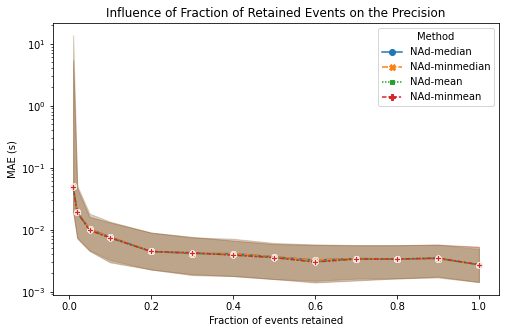

In [31]:
fig, axes = plt.subplots(1,1, figsize=(8, 5))

# melt the DataFrame
df_precision_melted = pd.melt(df_precision, id_vars="fraction", var_name="Method", 
                              value_vars=METHODS, value_name="precision")
precision_plot = sns.lineplot(data=df_precision_melted, 
                              x="fraction", y="precision", 
                              hue="Method", style="Method", markers=True,
                              estimator=np.median, errorbar=lambda x: (np.quantile(x, 0.25), np.quantile(x, 0.75)))

plt.title("Influence of Fraction of Retained Events on the Precision")
plt.xlabel("Fraction of events retained")
plt.ylabel("MAE (s)")
# plt.ylim((0.02, 50))
precision_plot.set(yscale='log')
# precision_plot.set(xscale='log')
plt.show()

### NAd-Optimization - Experiment: Use different DIST_MAX

TODO: check the results, they are not as expected

In [32]:
FACTORS = [0.01, 0.02, 0.05, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.2, 1.5, 2.0]
METHODS = ['NAd-median', 'NAd-minmedian', 'NAd-mean', 'NAd-minmean']  # TODO: add method specifics

SUBSELECT_LENGTH = 1000
SIGMA = 0.25               # run with a relative sigma of 0.1
FRACTION = 0.75            # run with a fraction of 0.9
MISS_BLOCK = 0.5
REGULATE_PADDINGS = True # False

In [33]:
# evaluate a given fraction
def evaluate_factor(factor):
    # generate semi-simulated pairs of measurements
    measurements = (heart_beat_dataset + breath_rate_dataset + step_rate_dataset)
    measurements = (breath_rate_dataset)
    semi_simulated_pairs = list()
    n_measurements = 0
    for measurement in measurements:
        for array in measurement:
            l_bound = max(TD_MIN, -len(array)/2, -SUBSELECT_LENGTH)
            u_bound = min(TD_MAX, len(array)/2, SUBSELECT_LENGTH)
            offset = np.random.random() * (u_bound-l_bound) + l_bound
            semi_simulated_pairs.append(
                (array, modify_timeseries(arr=array, offset=offset, subselect_length=SUBSELECT_LENGTH, 
                                          sigma=SIGMA, fraction=FRACTION, time_warp_scale=TIME_WARP_SCALE,
                                         miss_block=MISS_BLOCK),
                offset)
            )
            n_measurements += 1
    assert n_measurements == 2 * len(measurements)  # otherwise there ar !=2 arrays per measurement
    
    # define the local DataFrame for one single pair
    df_precision = pd.DataFrame({m: np.nan*np.zeros(n_measurements) for m in METHODS})
    df_precision["factor"] = [factor for _ in range(n_measurements)]

    # loop through all semi-simulated pairs
    for idx, (arr_ref, arr_sig, offset) in enumerate(semi_simulated_pairs):        
        # # NAd-dense
        # start_time = time.time()
        # np_nearest = nearest_advocate(
        #     arr_ref=arr_ref, arr_sig=arr_sig, 
        #     td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, sparse_factor=1, 
        #     dist_max=DIST_MAX, regulate_paddings=REGULATE_PADDINGS, dist_padding=DIST_MAX)
        # time_shift, min_mean_dist = np_nearest[np.argmin(np_nearest[:,1])]
        # df_precision.loc[idx, "NAd-dense"] = np.abs(time_shift-offset)

        # NAd-median
        start_time = time.time()
        dist_max = np.median(np.diff(arr_ref)) * factor
        np_nearest = nearest_advocate(
            arr_ref=arr_ref, arr_sig=arr_sig, 
            td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, sparse_factor=1, 
            dist_max=dist_max, regulate_paddings=REGULATE_PADDINGS, dist_padding=DIST_MAX)
        time_shift, min_mean_dist = np_nearest[np.argmin(np_nearest[:,1])]
        df_precision.loc[idx, "NAd-median"] = np.abs(time_shift-offset)

        # NAd-minmedian
        start_time = time.time()
        dist_max = min(np.median(np.diff(arr_sig)), np.median(np.diff(arr_ref))) * factor
        np_nearest = nearest_advocate(
            arr_ref=arr_ref, arr_sig=arr_sig, 
            td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, sparse_factor=1, 
            dist_max=dist_max, regulate_paddings=REGULATE_PADDINGS, dist_padding=DIST_MAX)
        time_shift, min_mean_dist = np_nearest[np.argmin(np_nearest[:,1])]
        df_precision.loc[idx, "NAd-minmedian"] = np.abs(time_shift-offset)

        # NAd-mean
        start_time = time.time()
        dist_max = np.mean(np.diff(arr_ref)) * factor
        np_nearest = nearest_advocate(
            arr_ref=arr_ref, arr_sig=arr_sig, 
            td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, sparse_factor=1, 
            dist_max=dist_max, regulate_paddings=REGULATE_PADDINGS, dist_padding=DIST_MAX)
        time_shift, min_mean_dist = np_nearest[np.argmin(np_nearest[:,1])]
        df_precision.loc[idx, "NAd-mean"] = np.abs(time_shift-offset)

        # NAd-minmedian
        start_time = time.time()
        dist_max = min(np.mean(np.diff(arr_sig)), np.mean(np.diff(arr_ref))) * factor
        np_nearest = nearest_advocate(
            arr_ref=arr_ref, arr_sig=arr_sig, 
            td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, sparse_factor=1, 
            dist_max=dist_max, regulate_paddings=REGULATE_PADDINGS, dist_padding=DIST_MAX)
        time_shift, min_mean_dist = np_nearest[np.argmin(np_nearest[:,1])]
        df_precision.loc[idx, "NAd-minmean"] = np.abs(time_shift-offset)

    return df_precision
    
# Initialize the pool with the number of processes
with Pool(processes=16) as pool: 
    results = pool.map(evaluate_factor, FACTORS)
df_precision = pd.concat(results).sort_values("factor")
df_precision.head(5)

,NAd-median,NAd-minmedian,NAd-mean,NAd-minmean,factor
0,250.560221,250.560221,250.560221,250.560221,0.01
21,25.906203,25.906203,25.906203,25.906203,0.01
22,46.862967,46.862967,46.862967,46.862967,0.01
23,384.550412,384.550412,384.550412,384.550412,0.01
24,298.258897,298.258897,232.958893,232.958893,0.01


In [34]:
df_precision.sample(5)

,NAd-median,NAd-minmedian,NAd-mean,NAd-minmean,factor
36,46.666150,46.666150,46.666150,46.666150,0.02
33,0.010813,0.010813,0.010813,0.010813,0.70
10,0.013667,0.013667,0.013667,0.013667,0.90
6,0.028431,0.028431,0.028431,0.028431,0.50
34,0.047100,0.047100,0.037102,0.037102,0.25


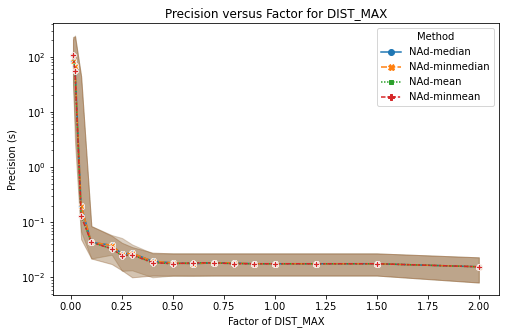

In [35]:
fig, axes = plt.subplots(1,1, figsize=(8, 5))

# melt the DataFrame
df_precision_melted = pd.melt(df_precision, id_vars="factor", var_name="Method", 
                              value_vars=METHODS, value_name="precision")
precision_plot = sns.lineplot(data=df_precision_melted, 
                              x="factor", y="precision", 
                              hue="Method", style="Method", markers=True, 
                              estimator=np.median, errorbar=lambda x: (np.quantile(x, 0.25), np.quantile(x, 0.75)))

plt.title("Precision versus Factor for DIST_MAX")
plt.xlabel("Factor of DIST_MAX")
plt.ylabel("Precision (s)")
# plt.ylim((0.0, 0.5))
precision_plot.set(yscale='log')
# precision_plot.set(xscale='log')
plt.show()

In [37]:
df_precision_melted.sort_values("precision").head(10)

,factor,Method,precision
1427,0.10,NAd-mean,0.000221
2043,0.05,NAd-minmean,0.000221
2073,0.10,NAd-minmean,0.000221
2385,0.80,NAd-minmean,0.000221
1236,1.50,NAd-minmedian,0.000221
1198,1.20,NAd-minmedian,0.000221
2422,0.90,NAd-minmean,0.000221
1397,0.05,NAd-mean,0.000221
590,1.50,NAd-median,0.000221
1169,1.00,NAd-minmedian,0.000221


In [38]:
df_precision_melted.groupby(["factor", "Method"]).agg({"precision": "mean"}).sort_values("precision")

precision
factor Method                   
2.00   NAd-minmedian    0.017877
       NAd-median       0.017877
       NAd-mean         0.017877
       NAd-minmean      0.017877
0.80   NAd-mean         0.020589
       NAd-minmean      0.020589
0.90   NAd-mean         0.020589
       NAd-minmean      0.020589
       NAd-minmedian    0.020589
1.00   NAd-mean         0.020589
       NAd-median       0.020589
       NAd-minmean      0.020589
0.90   NAd-median       0.020589
1.20   NAd-mean         0.020589
       NAd-median       0.020589
       NAd-minmean      0.020589
       NAd-minmedian    0.020589
1.50   NAd-mean         0.020589
       NAd-median       0.020589
       NAd-minmean      0.020589
       NAd-minmedian    0.020589
1.00   NAd-minmedian    0.020589
0.50   NAd-minmean      0.020841
       NAd-mean         0.020841
0.80   NAd-minmedian    0.020852
       NAd-median       0.020852
0.70   NAd-minmean      0.021104
       NAd-mean         0.021104
0.60   NAd-minmedian    0.021104
       NAd-median       0.021104
       NAd-minmean      0.021116
       NAd-mean         0.021116
0.70   NAd-median       0.021367
       NAd-minmedian    0.021367
0.40   NAd-median       0.021613
       NAd-minmedian    0.021613
0.50   NAd-median       0.021630
       NAd-minmedian    0.021630
0.40   NAd-minmean      0.022050
       NAd-mean         0.022050
0.30   NAd-minmean      0.025452
       NAd-mean         0.025452
       NAd-minmedian    0.029797
       NAd-median       0.029797
0.25   NAd-mean         0.031842
       NAd-minmean      0.031842
       NAd-median       0.034763
       NAd-minmedian    0.034763
0.20   NAd-minmean      5.237194
       NAd-mean         5.237194
       NAd-minmedian    5.242000
       NAd-median       5.242000
0.10   NAd-minmedian   15.418333
       NAd-median      15.418333
       NAd-minmean     15.419385
       NAd-mean        15.419385
0.05   NAd-minmean     59.397059
       NAd-mean        59.397059
       NAd-minmedian   60.324913
       NAd-median      60.324913
0.02   NAd-minmean    114.048006
       NAd-mean       114.048006
       NAd-minmedian  126.765339
       NAd-median     126.765339
0.01   NAd-minmedian  129.885977
       NAd-median     129.885977
       NAd-minmean    146.378310
       NAd-mean       146.378310